# Johan Hedenström
Exploration

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.data import load_tof, Phi
from utils.plot import plot_predictions, make_palette
from image_processing_filter import process
from scipy.optimize import curve_fit
from utils.trajectory import fit, fx, find_domain

from models.mixture import MixIRLS

In [2]:
def add_bias(X):
    return np.c_[np.ones(len(X)), X]

In [3]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst' # I_36MeV_SH2-3_SiC-ref.lst, I_36MeV_SH2-1_TiN-ref.lst
X, y, phi = load_tof(FILE_PATH)
X, y = process(X,y, noise_sensitivity=0.9)
phi = Phi(X)
data = np.vstack([X,y,phi.flatten()]).T
data = np.unique(data, axis=0)
X, y, phi = data[:,0], data[:,1], data[:,2]

In [4]:
K = 3
wfun = lambda r: 1 / (1+r**2)
plot = False
alpha = 1

model = MixIRLS(K=K, wfun=wfun, plot=plot, alpha=alpha)

exponents = [-1/i for i in range(2, 30)]
phi = Phi(X, exponents)

sprim, supports, iter = model.train(phi, y)
y_pred = model.predict(phi)

Trajectory 0: -abs(5971.92744786066) / np.sqrt(abs(x + 20.086334555120906)) + 1185.7864051656568, domain: (19, 1148.9038076152303)
Trajectory 1: -abs(3307.0144268669333) / np.sqrt(abs(x + 14.748124319745491)) + 1188.7163072801543, domain: (19, 569.9158316633267)
Trajectory 2: -abs(9152.888438435317) / np.sqrt(abs(x + 27.449949757345067)) + 1155.8666613037205, domain: (19, 682.2044088176352)


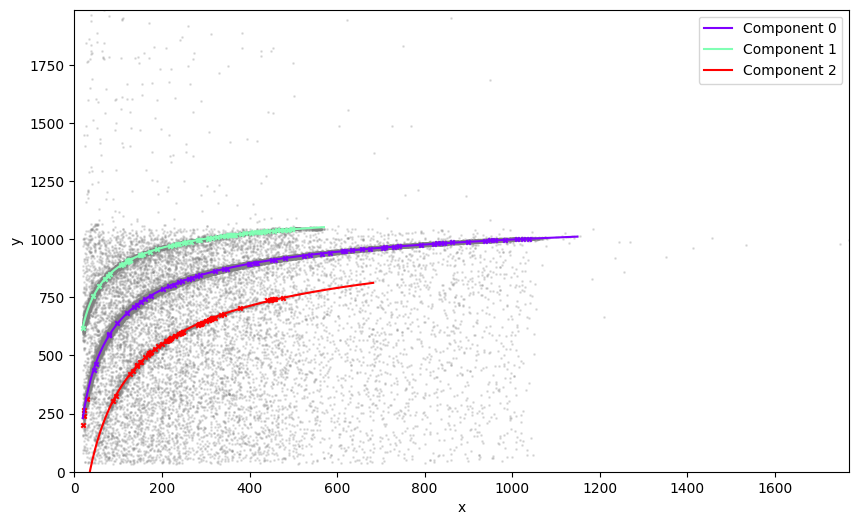

In [5]:
plt.figure(figsize=(10, 6))
colors = make_palette(K)

X_raw, y_raw, _ = load_tof(FILE_PATH)

plt.scatter(X_raw, y_raw, alpha=0.2, s=1, color='grey')

for k in range(K):
    i = supports[:, k]  # Points in the cluster
    j = sprim[k]  # Points used for fitting

    params = fit(X[i][j], y[i][j], X[i], y[i])    
    plt.scatter(X[i][j], y[i][j], alpha=1, s=10, marker='x', color=colors[k])

    domain = find_domain(X_raw, y_raw, params)
    print(f'Trajectory {k}: -abs({params[0]}) / np.sqrt(abs(x + {params[1]})) + {params[2]}, domain: ({domain[0]}, {domain[1]})')
    
    x_fit = np.linspace(domain[0], domain[1], 500)
    y_fit = fx(x_fit, *params)

    # Plot the fitted curve
    plt.plot(x_fit, y_fit, color=colors[k], label=f"Component {k}")

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0, max(X_raw)])
plt.ylim([0, max(y_raw)])
plt.legend()
plt.show()
